In this notebook, we're going to explore the classification system used by the Libary of Congress (the system that most university libraries are organized by).  Every book in the LOC system is assigned a *single* classification from a hierarchy (see [here](https://www.loc.gov/catdir/cpso/lcco/) for more details); even if a book is "about" multiple topics within this system, only a single label can be chosen.  This choice is determined in part by constraints of the physical world -- even if a work spans multiple topics, a physical book can only be placed on a single shelf in a library.

We'll examine this system at two levels:

* The top-most level (A, B, C, ... Z) (``../data/loc.all.txt``)
* The narrower category of P ("Philology and Linguistics") (``../data/loc.p.txt``)

We're going to train a classifier using a bag-of-words representation on the *titles* of books to predict which category the book belongs to -- not because we want to build an automatic system for LOC classification, but rather to understand the boundaries between the categories.

You can run this notebook on either dataset by plugging the appropriate file into the `read_data` function below. The data for this notebook comes from the Library of Congress catalogue, which is openly available here:

https://www.loc.gov/cds/products/MDSConnect-books_all.html

The data in this repo includes a sample of English texts from this LOC data with titles at least 25 characters long.  The data is balanced so that each class is represented the same number of times (1000 times for top-level categories, and 200 times for P subcategories).

<font color="red">1. First, let's analyze the top-level categories.</font>

In [1]:
import json
import nltk
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from scipy import sparse
from collections import Counter
import operator
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt
import sklearn
import pandas as pd
from pandas import option_context

In [2]:
def read_data(filename):
    
    data=[]
    X=[]
    Y=[]
    
    with open(filename, encoding="utf-8") as file:
        for line in file:
            cols=line.rstrip().split("\t")
            cat=cols[0]
            title=cols[1].lower()
            tokens=nltk.word_tokenize(title)
            X.append(tokens)
            Y.append(cat)  
                
    return X, Y 

In [3]:
X, Y=read_data("../data/loc.all.txt")

Split the data into training and validation sets (hold out 20% of the data for evaluation).

In [4]:
trainX, devX, trainY, devY = train_test_split(X, Y, test_size=0.2, random_state=0, stratify=Y)

In [5]:
def build_features(dataX, feature_functions):
    
    """ This function featurizes the data according to the list of parameter feature_functions """
    
    data=[]
    for tokens in dataX:
        feats={}
        
        for function in feature_functions:
            feats.update(function(tokens))

        data.append(feats)
    return data

In [6]:
def features_to_ids(data, feature_vocab):
    
    """ 
    
    This helper function converts a dictionary of feature names to a sparse representation
 that we can fit in a scikit-learn model.  This is important because almost all feature 
 values will be 0 for most documents (note: why?), and we don't want to save them all in 
 memory.

    """
    new_data=sparse.lil_matrix((len(data), len(feature_vocab)))
    for idx,doc in enumerate(data):
        for f in doc:
            if f in feature_vocab:
                new_data[idx,feature_vocab[f]]=doc[f]
    return new_data

In [7]:
def create_vocab(data, top_n=None):
    
    """ 
    
    This helper function converts a dictionary of feature names to unique numerical ids. 
    top_n limits the features to only the n most frequent features observed in the training data 
    (in terms of the number of documents that contains it).
    
    """
    
    counts=Counter()
    for doc in data:
        for feat in doc:
            counts[feat]+=1

    feature_vocab={}

    for idx, (k, v) in enumerate(counts.most_common(top_n)):
        feature_vocab[k]=idx
                
    return feature_vocab

In [8]:
def pipeline(trainX, devX, trainY, devY, feature_functions):

    """ This function evaluates a list of feature functions on the training/dev data arguments """
    
    trainX_feat=build_features(trainX, feature_functions)
    devX_feat=build_features(devX, feature_functions)

    # just create vocabulary from features in *training* data.
    feature_vocab=create_vocab(trainX_feat, top_n=100000)

    trainX_ids=features_to_ids(trainX_feat, feature_vocab)
    devX_ids=features_to_ids(devX_feat, feature_vocab)
    
    clf = linear_model.LogisticRegression(C=100, solver='lbfgs', penalty='l2', max_iter=10000)
    clf.fit(trainX_ids, trainY)
    print("Accuracy: %.3f" % clf.score(devX_ids, devY))
    
    return clf, feature_vocab, devX_ids

In [9]:
def majority_class(trainY, devY):
    labelCounts=Counter()
    for label in trainY:
        labelCounts[label]+=1
    majority_class=labelCounts.most_common(1)[0][0]
    
    correct=0.
    for label in devY:
        if label == majority_class:
            correct+=1
            
    print("%s\t%.3f" % (majority_class, correct/len(devY)))

In [10]:
majority_class(trainY, devY)

A	0.048


In [11]:
def unigram_feature(tokens):
    feats={}
    for word in tokens:
        feats["UNIGRAM_%s" % word]=1
    return feats

In [12]:
features=[unigram_feature]
clf, vocab, devX_ids=pipeline(trainX, devX, trainY, devY, features)

Accuracy: 0.502


Let's analyze performance by class

In [13]:
def analyze_class_performance(clf, devX_ids):
    dev_pred=clf.predict(devX_ids)

    vals=sklearn.metrics.classification_report(devY, dev_pred, output_dict=True)
    print("F1\tClass")
    for key in vals:
        if key in clf.classes_:
            val=vals[key]
            print("%.3f\t%s" % (vals[key]["f1-score"], key))

In [14]:
analyze_class_performance(clf, devX_ids)

F1	Class
0.406	A
0.447	B
0.558	C
0.365	D
0.425	E
0.466	F
0.480	G
0.382	H
0.475	J
0.632	K
0.604	L
0.219	M
0.599	N
0.346	P
0.509	Q
0.607	R
0.554	S
0.453	T
0.675	U
0.738	V
0.636	Z


Let's print out the top 10 features with the strongest weights for each class

In [15]:
def print_weights(clf, vocab, n=10):

    reverse_vocab=[None]*len(clf.coef_[0])
    for k in vocab:
        reverse_vocab[vocab[k]]=k
        
    for i, cat in enumerate(clf.classes_):
        
        weights=clf.coef_[i]

        for feature, weight in list(reversed(sorted(zip(reverse_vocab, weights), key = operator.itemgetter(1))))[:n]:
            print("%s\t%.3f\t%s" % (cat, weight, feature))
        print()

In [16]:
print_weights(clf, vocab, n=10)

A	10.134	UNIGRAM_museums
A	7.466	UNIGRAM_museum
A	6.378	UNIGRAM_samoan
A	6.103	UNIGRAM_humanities
A	5.967	UNIGRAM_menageries
A	5.894	UNIGRAM_exhibits
A	5.796	UNIGRAM_pamphlets
A	5.774	UNIGRAM_encyclopedia
A	5.619	UNIGRAM_comment
A	5.479	UNIGRAM_illuminated

B	7.059	UNIGRAM_islam
B	6.960	UNIGRAM_theology
B	6.627	UNIGRAM_christianity
B	6.472	UNIGRAM_missionary
B	6.377	UNIGRAM_joy
B	6.328	UNIGRAM_church
B	6.087	UNIGRAM_testament
B	6.018	UNIGRAM_christian
B	5.990	UNIGRAM_religion
B	5.880	UNIGRAM_humanism

C	9.418	UNIGRAM_coins
C	7.236	UNIGRAM_archaeological
C	7.061	UNIGRAM_descendants
C	6.898	UNIGRAM_flag
C	6.632	UNIGRAM_family
C	6.540	UNIGRAM_genealogical
C	6.528	UNIGRAM_archaeology
C	6.397	UNIGRAM_heraldry
C	6.319	UNIGRAM_bluestockings
C	5.859	UNIGRAM_genealogy

D	6.058	UNIGRAM_afghanistan
D	5.742	UNIGRAM_1509-1815
D	5.646	UNIGRAM_greece
D	5.622	UNIGRAM_russia
D	5.535	UNIGRAM_pohnpei
D	5.342	UNIGRAM_folkestone
D	5.322	UNIGRAM_cry
D	5.194	UNIGRAM_blue
D	5.174	UNIGRAM_arthurian
D	5.043	UNI

Now let's analyze the boundaries between categories through a confusion matrix on the test data

In [17]:
def print_confusion(clf, devX_ids, devY):
    fig, ax = plt.subplots(figsize=(15, 15))
    plot_confusion_matrix(clf, devX_ids, devY, ax=ax, xticks_rotation="vertical")
    plt.show()

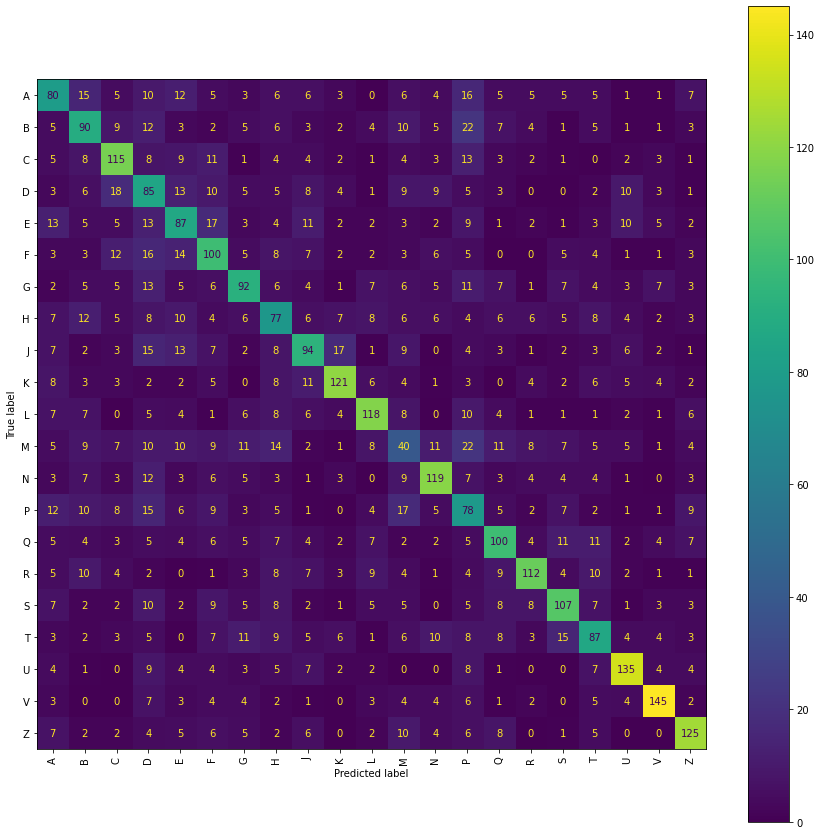

In [18]:
print_confusion(clf, devX_ids, devY)

For reference, here are the meanings of the top-level LOC classes:

https://www.loc.gov/catdir/cpso/lcco/

|category|description|
|:---|:---|
|A|GENERAL WORKS|
|B|PHILOSOPHY. PSYCHOLOGY. RELIGION|
|C|AUXILIARY SCIENCES OF HISTORY|
|D|WORLD HISTORY AND HISTORY OF EUROPE, ASIA, AFRICA, AUSTRALIA, NEW ZEALAND, ETC.|
|E|HISTORY OF THE AMERICAS|
|F|HISTORY OF THE AMERICAS|
|G|GEOGRAPHY. ANTHROPOLOGY. RECREATION|
|H|SOCIAL SCIENCES|
|J|POLITICAL SCIENCE|
|K|LAW|
|L|EDUCATION|
|M|MUSIC AND BOOKS ON MUSIC|
|N|FINE ARTS|
|P|LANGUAGE AND LITERATURE|
|Q|SCIENCE|
|R|MEDICINE|
|S|AGRICULTURE|
|T|TECHNOLOGY|
|U|MILITARY SCIENCE|
|V|NAVAL SCIENCE|
|Z|BIBLIOGRAPHY. LIBRARY SCIENCE. INFORMATION RESOURCES (GENERAL)|

Now, let's analyze the mistakes -- the specific data points where the prediction doesn't agree with the human labeler.  We'll examine these by looking at the *highest-confidence predictions* -- the predictions that have the highest probability for an incorrect label.

In [19]:
def analyze(clf, devX_ids, devX, devY):
    
    probs=clf.predict_proba(devX_ids)
    predicts=clf.predict(devX_ids)

    classes={}
    for idx, lab in enumerate(clf.classes_):
        classes[lab]=idx

    mistakes={}
    for i in range(len(probs)):
        if predicts[i] != devY[i]:
            predicted_lab_idx=classes[predicts[i]]
            mistakes[i]=probs[i][predicted_lab_idx]

    frame=[]
    sorted_x = sorted(mistakes.items(), key=operator.itemgetter(1), reverse=True)
    for k, v in sorted_x:
        frame.append([v, devY[k], predicts[k], ' '.join(devX[k])])

    df=pd.DataFrame(frame, columns=["P(predicted class)", "Human label", "Prediction", "Title"])

    with option_context('display.max_colwidth', 400):
        display(df.head(n=20))

In [20]:
analyze(clf, devX_ids, devX, devY)

,P(predicted class),Human label,Prediction,Title
0,1.000000,P,Z,"lot 931 -- a reconstruction : books , periodicals , and ephemera from the brownings ' library /"
1,1.000000,T,S,"the complete guide to building classic barns , fences , storage sheds , animal pens , outbuildings , greenhouses , farm equipment , & tools : a step-by-step guide to building everything you might need on a small farm : with companion cd-rom ."
2,1.000000,M,R,ryan white care act : improved oversight needed to ensure aids drug assistance programs obtain best prices for drugs : report to congressional requesters /
3,1.000000,D,J,"the governing passion ; cabinet government and party politics in britain , 1885-86 ,"
4,0.999999,S,Z,"a list of log books of whaling voyages in the collection of the melville whaling room in the free public library , new bedford , massachusetts . none"
5,0.999998,M,H,"foreign direct investment , regional economic integration , and industrial restructuring in asia trends , patterns , and prospects /"
6,0.999996,L,J,"atomic energy ; application of safeguards by the iaea to the united states -- republic of korea cooperation agreement . agreement between the united states of america , the republic of korea and the international atomic energy agency , signed at vienna january 5 , 1968 ."
7,0.999993,A,R,"an essay upon nursing , and the management of children , from their birth to three years of age : in a letter to one of the governors of the foundling hospital /"
8,0.999992,M,B,king of glory : the life and teaching of jesus christ in the synoptic gospels /
9,0.999991,M,H,"commercial automobile markets : solid sectors , worthy gambles , and risky business ."


<font color="red">2. Now go back to the top</font> and replace `loc.all.txt` with `loc.p.txt` in `read_data` to zoom in on a narrower slice on the LOC classification system -- the P's capturing "Philology and Linguistics".  Replace that file and execute the rest of the following cells to analyze the categories in this subset.